# Lab 1
**Author:** Molozhavenko Alexander 

**Group:** B05-904a

---

# Plan


1.   Data Preparation
2.   Exploratory Data Analysis
3.   Construction and selection of models
4.   Final results and conclusions



---

In [1]:
import math
import scipy
import warnings
import math as m
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
plt.rcParams['figure.figsize'] = 11, 7
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 16

In [3]:
data_subjects_info_path = "/content/drive/MyDrive/MFM_Lab1_data/data_subjects_info.csv"
A_DeviceMotion_data_path = "/content/drive/MyDrive/MFM_Lab1_data/A_DeviceMotion_data"

# 1) Data Preparation 

## a) Data praparing functions and data

I've chosen the first introduced dataset: Walk accelerometer. The exact same code as in [source](https://github.com/mmalekzadeh/motion-sense) below:

In [4]:
def get_ds_infos():

    dss = pd.read_csv(data_subjects_info_path)
    print("[INFO] -- Data subjects' information is imported.")
    
    return dss

def set_data_types(data_types=["userAcceleration"]):

    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])

    return dt_list


def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):

    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = A_DeviceMotion_data_path + '/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset

ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

sdt = ["attitude", "userAcceleration"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS [0:4]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog']
[INFO] -- Data subjects' information is imported.
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(767660, 13)


In [5]:
data = dataset.loc[dataset['id'] == 0]
data = data.loc[data['trial'] == 15]
data = data.loc[data['act'] == 2.0]
data = data.reset_index().drop(columns='index')
clear_output()

---

## b) Obtained data

I've chosen activity "walking" as well as my colleague Lukyanenko Ivan as soon as he picked Simple Neural Network method. Such choise will let us compare our results.

In [6]:
data.tail()

,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id,weight,height,age,gender,trial
1328,-1.407369,-1.321268,-2.492674,0.045689,0.611858,-0.873182,2.0,0.0,102.0,188.0,46.0,1.0,15.0
1329,-1.384460,-1.312720,-2.446773,0.404748,1.027273,-0.621450,2.0,0.0,102.0,188.0,46.0,1.0,15.0
1330,-1.374939,-1.314014,-2.428457,0.407576,0.258908,-0.084899,2.0,0.0,102.0,188.0,46.0,1.0,15.0
1331,-1.390733,-1.319325,-2.454290,0.230798,-0.047420,0.175331,2.0,0.0,102.0,188.0,46.0,1.0,15.0
1332,-1.404754,-1.320913,-2.480884,-0.183692,-0.401772,0.111459,2.0,0.0,102.0,188.0,46.0,1.0,15.0


From the [source](https://github.com/mmalekzadeh/motion-sense) we know that measurements were taken with frquency of $50$ Hz. So we have $1332$ measurements this means that time of trial is $1332 / 50 = 26.64 \; \text{sec} $

---

# 2) Exploratory Data Analysis

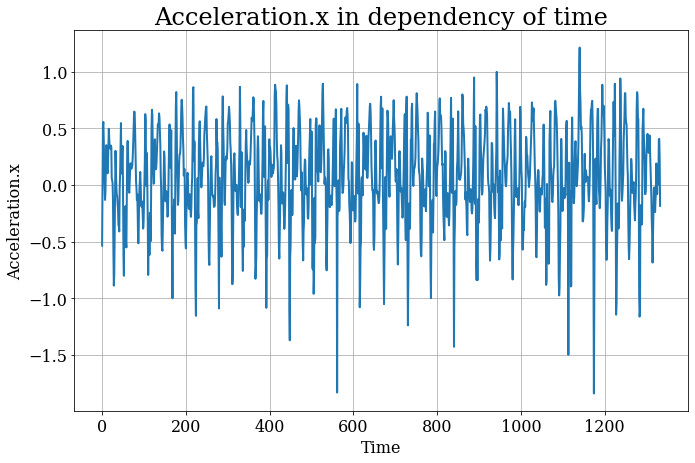

In [7]:
plt.plot(data['userAcceleration.x'])
plt.xlabel("Time")
plt.ylabel("Acceleration.x")
plt.title("Acceleration.x in dependency of time")
plt.grid()
plt.show()

Now it is obvious that data does not have a global seasonal factor,which is proven by autocorrelation graph. At the same time, seasonal factor is local: steps are similar to each other (look at "Acceleration vector norm in dependency of time" grarph). So I will use exponential smoothing (level) and double exponential smoothing (level and trend) and Holt-Winters Exponential Smoothing (level, trend and season).

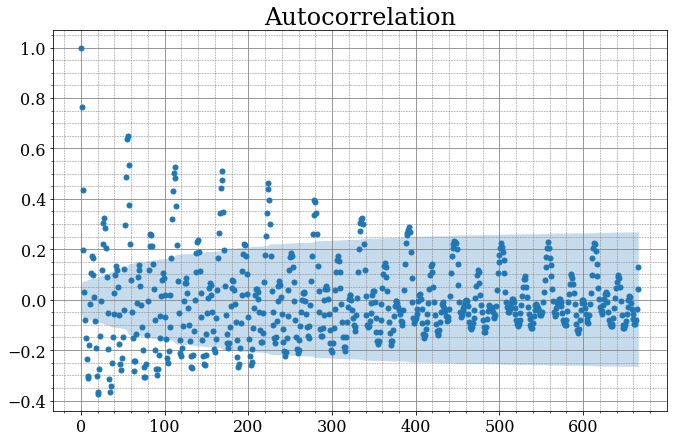

In [8]:
plot_acf(
    data['userAcceleration.x'],
    lags = int(len(data['userAcceleration.x'])/2),
    use_vlines = False,
    alpha=0.1
) 
plt.tick_params(axis='both', which='major')
plt.grid(which='major',
    color = 'gray', 
    linewidth = 0.8)
plt.minorticks_on()
plt.grid(which='minor', 
    color = 'gray', 
    linestyle = '--',
    linewidth = 0.5)
plt.show()

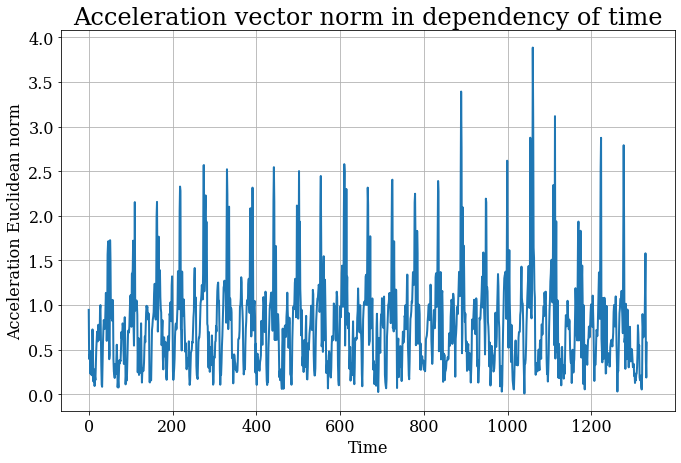

In [9]:
plt.plot(np.sqrt(data['userAcceleration.y'] ** 2 + data['userAcceleration.y'] ** 2 + data['userAcceleration.z'] ** 2))
plt.xlabel("Time")
plt.ylabel("Acceleration Euclidean norm")
plt.title("Acceleration vector norm in dependency of time")
plt.grid()
plt.show()

In this graph we can easily determine every step!

# 3) Construction and selection of models

## I) Models Demonstration

In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt

In [11]:
data_piece = data['userAcceleration.x'].iloc[1:300]

### a) Simple Exponentional Smothing

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


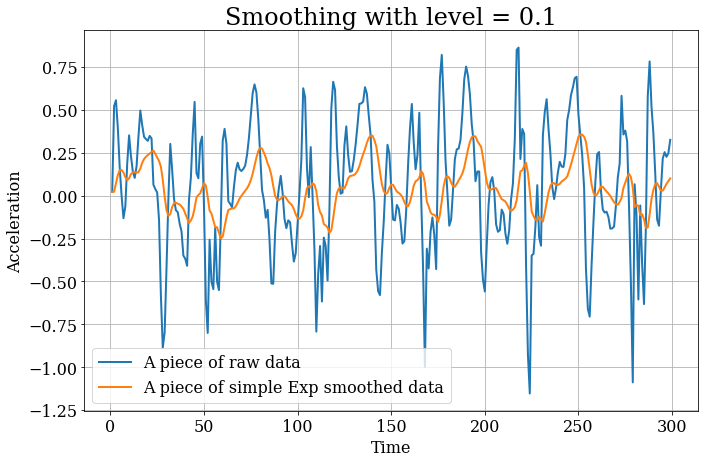

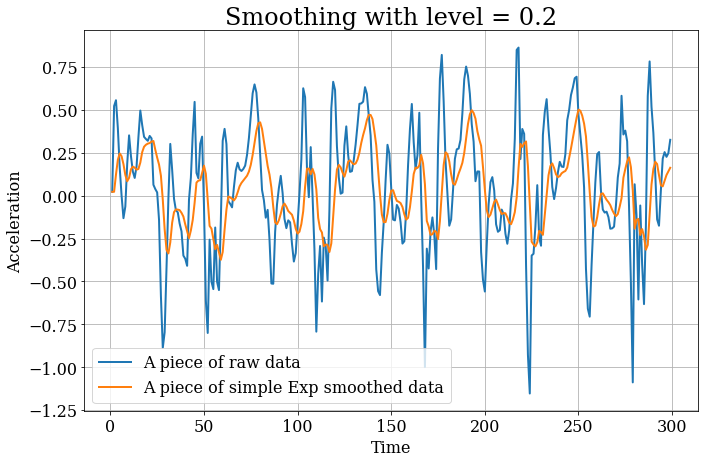

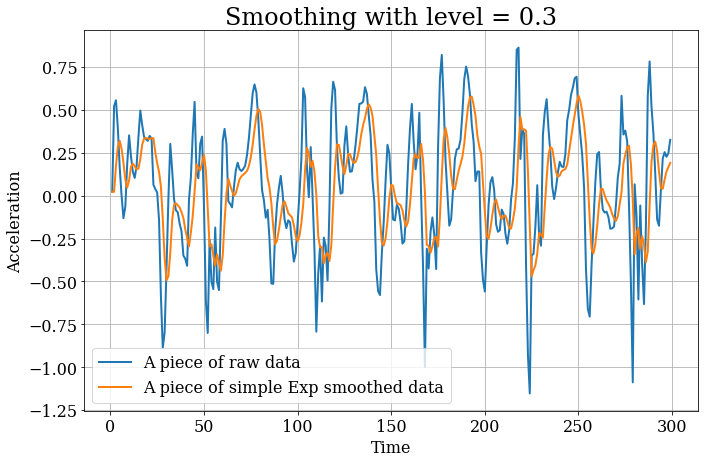

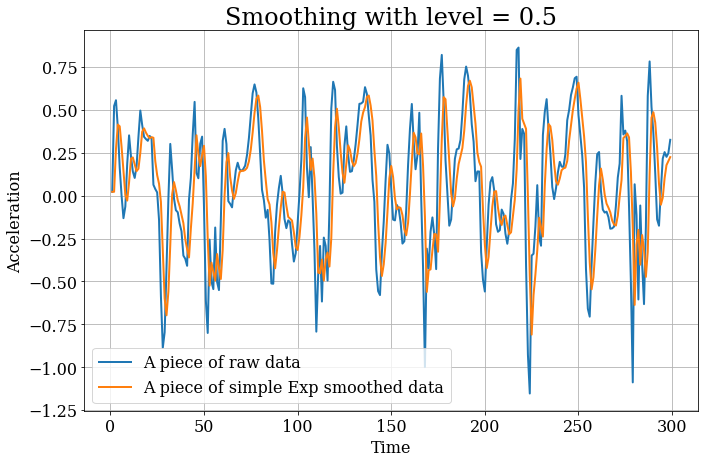

In [12]:
smoothing_levels = [0.1, 0.2, 0.3, 0.5]
sses = []

for smoothing_level in smoothing_levels:  
  smoothed = SimpleExpSmoothing(data_piece).fit(smoothing_level=smoothing_level, optimized=False)
  sm_data_piece = smoothed.fittedvalues

  sses.append(smoothed.sse)
  plt.plot(data_piece, label = "A piece of raw data")
  plt.plot(sm_data_piece, label = "A piece of simple Exp smoothed data")
  plt.xlabel("Time")
  plt.ylabel("Acceleration")
  plt.title(f"Smoothing with level = {smoothing_level}")
  plt.grid()
  plt.legend()
  plt.show()

In [13]:
for smoothing_level, sse in zip(smoothing_levels, sses):
  print(f"For smoothing level = {smoothing_level} the sum of squared errors between the data and the fittted value = {sse}")

For smoothing level = 0.1 the sum of squared errors between the data and the fittted value = 39.61650871207025
For smoothing level = 0.2 the sum of squared errors between the data and the fittted value = 35.68404924611347
For smoothing level = 0.3 the sum of squared errors between the data and the fittted value = 31.87092181366362
For smoothing level = 0.5 the sum of squared errors between the data and the fittted value = 25.661105683773467


### b) Double Exponentional Smoothing

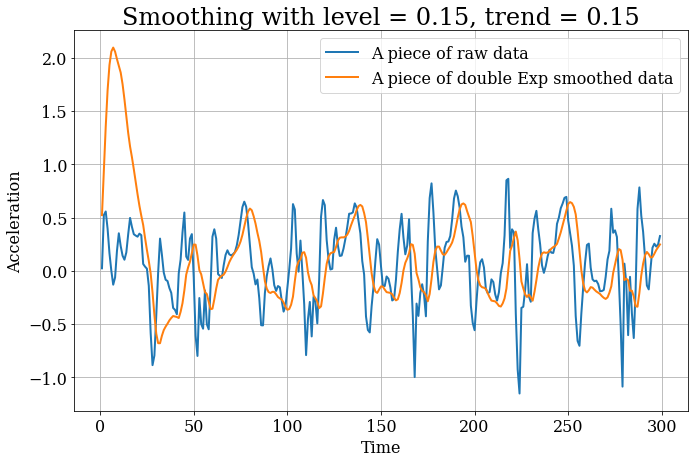

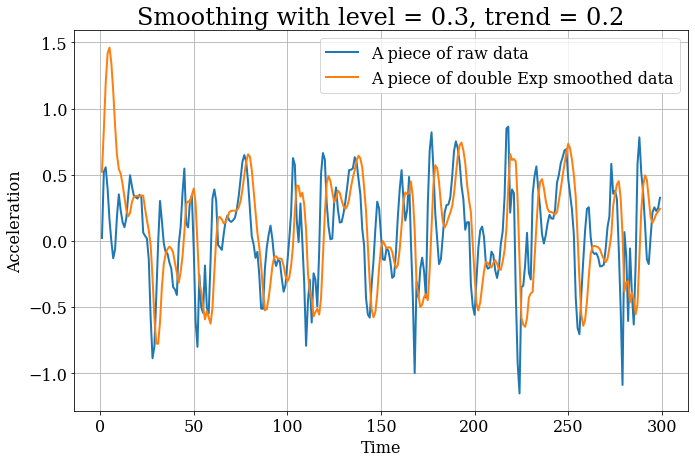

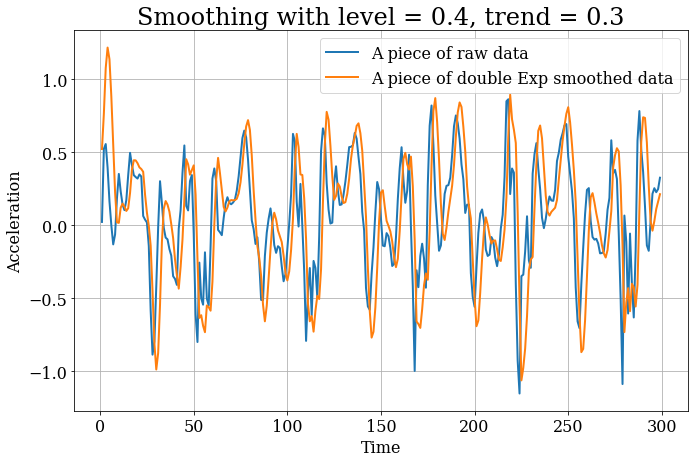

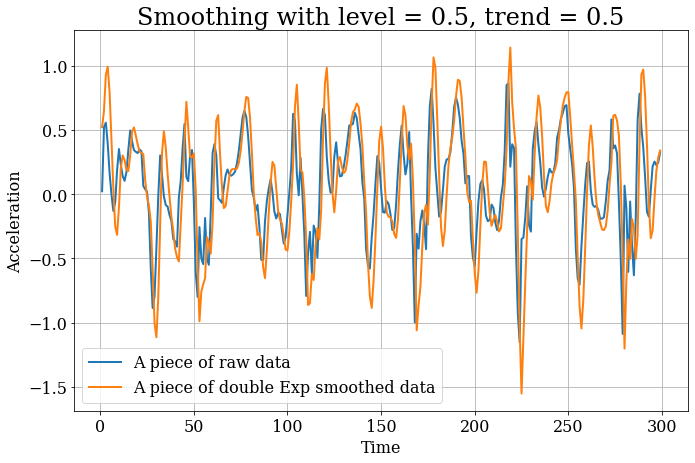

In [14]:
smoothing_levels = [0.15, 0.2, 0.3, 0.5]
smoothing_trends = [0.15, 0.3, 0.4, 0.5]
sses = []
exp_am = len(smoothing_levels)

for smoothing_trend, smoothing_level in zip(smoothing_levels, smoothing_trends):  
  smoothed = Holt(data_piece).fit(smoothing_level=smoothing_level, smoothing_trend=smoothing_trend, optimized=False)
  sm_data_piece = smoothed.fittedvalues

  sses.append(smoothed.sse)
  plt.plot(data_piece, label = "A piece of raw data")
  plt.plot(sm_data_piece, label = "A piece of double Exp smoothed data")
  plt.xlabel("Time")
  plt.ylabel("Acceleration")
  plt.title(f"Smoothing with level = {smoothing_level}, trend = {smoothing_trend}")
  plt.grid()
  plt.legend()
  plt.show()

In [15]:
for i in range(exp_am):
  print(f"For smoothing level = {smoothing_levels[i]}, smoothing_trend = {smoothing_trends[i]} the sum of squared errors between the data and the fittted value = {sses[i]}")

For smoothing level = 0.15, smoothing_trend = 0.15 the sum of squared errors between the data and the fittted value = 85.28378545343135
For smoothing level = 0.2, smoothing_trend = 0.3 the sum of squared errors between the data and the fittted value = 50.125724490389516
For smoothing level = 0.3, smoothing_trend = 0.4 the sum of squared errors between the data and the fittted value = 43.19385279992207
For smoothing level = 0.5, smoothing_trend = 0.5 the sum of squared errors between the data and the fittted value = 36.29130453830041


### c) Holt-Winters Exponential Smoothing

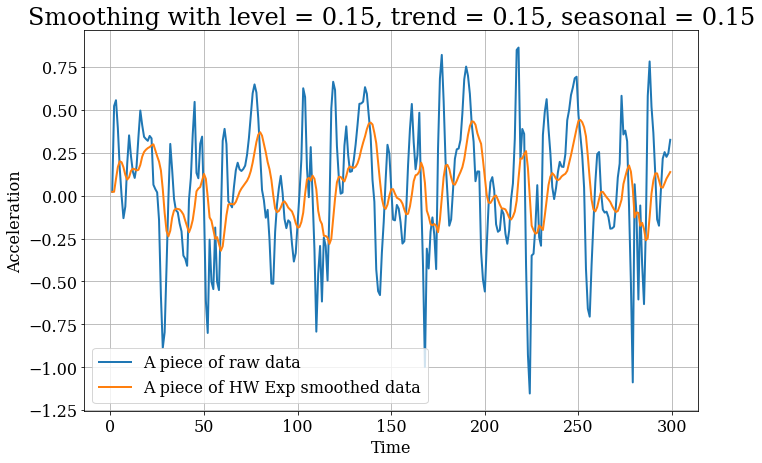

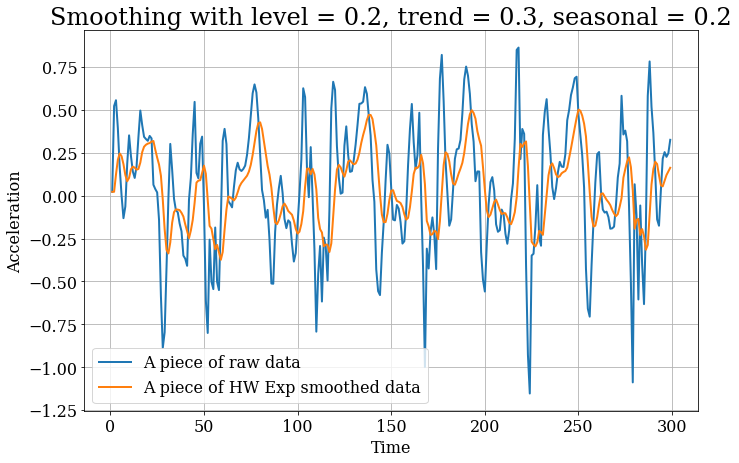

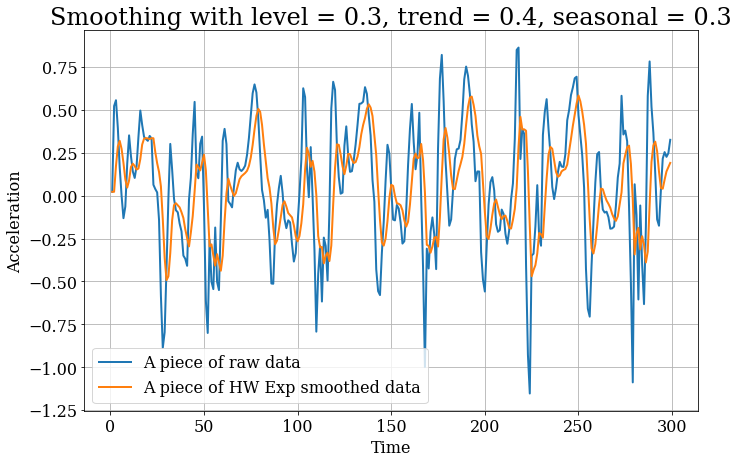

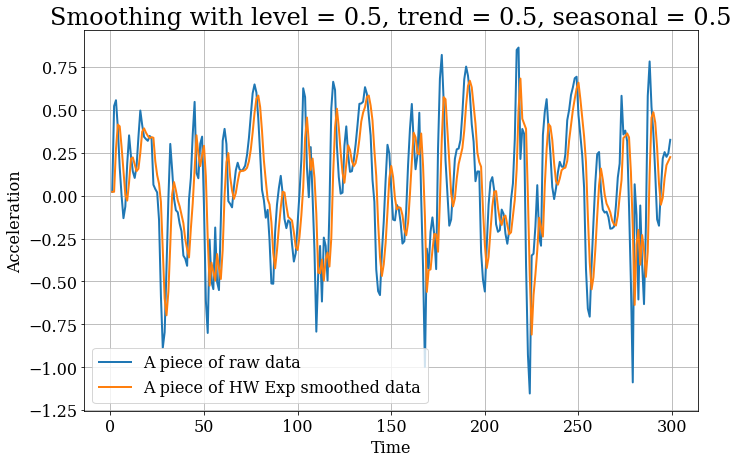

In [16]:
smoothing_levels = [0.15, 0.2, 0.3, 0.5]
smoothing_trends = [0.15, 0.3, 0.4, 0.5]
smoothing_seasonals = [0.15, 0.2, 0.3, 0.5]
sses = []
exp_am = len(smoothing_levels)

for i in range(exp_am):  
  smoothed = ExponentialSmoothing(data_piece).fit(smoothing_level=smoothing_levels[i], smoothing_trend=smoothing_trends[i], smoothing_seasonal = smoothing_seasonals[i], optimized=False)
  sm_data_piece = smoothed.fittedvalues

  sses.append(smoothed.sse)
  plt.plot(data_piece, label = "A piece of raw data")
  plt.plot(sm_data_piece, label = "A piece of HW Exp smoothed data")
  plt.xlabel("Time")
  plt.ylabel("Acceleration")
  plt.title(f"Smoothing with level = {smoothing_levels[i]}, trend = {smoothing_trends[i]}, seasonal = {smoothing_seasonals[i]}")
  plt.grid()
  plt.legend()
  plt.show()

In [17]:
for i in range(exp_am):
  print(f"For smoothing level = {smoothing_levels[i]}, smoothing trend = {smoothing_trends[i]}, smoothing seasonal = {smoothing_seasonals[i]} the sum of squared errors between the data and the fittted value = {sses[i]}")

For smoothing level = 0.15, smoothing trend = 0.15, smoothing seasonal = 0.15 the sum of squared errors between the data and the fittted value = 37.66741291962357
For smoothing level = 0.2, smoothing trend = 0.3, smoothing seasonal = 0.2 the sum of squared errors between the data and the fittted value = 35.68404924611347
For smoothing level = 0.3, smoothing trend = 0.4, smoothing seasonal = 0.3 the sum of squared errors between the data and the fittted value = 31.87092181366362
For smoothing level = 0.5, smoothing trend = 0.5, smoothing seasonal = 0.5 the sum of squared errors between the data and the fittted value = 25.661105683773467


## II) Accuracy competition  

In [18]:
train= data['userAcceleration.x'].iloc[0:1125]
test = data['userAcceleration.x'].iloc[1125:]

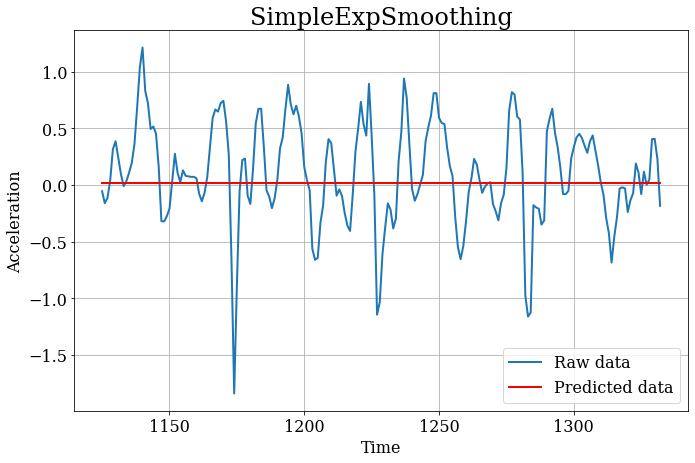

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning,


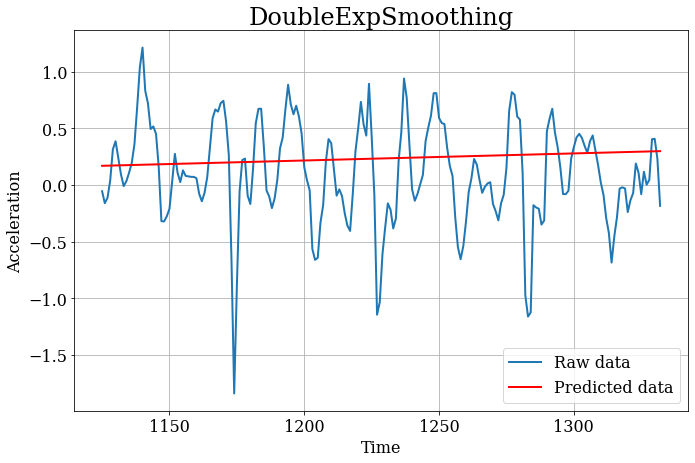

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


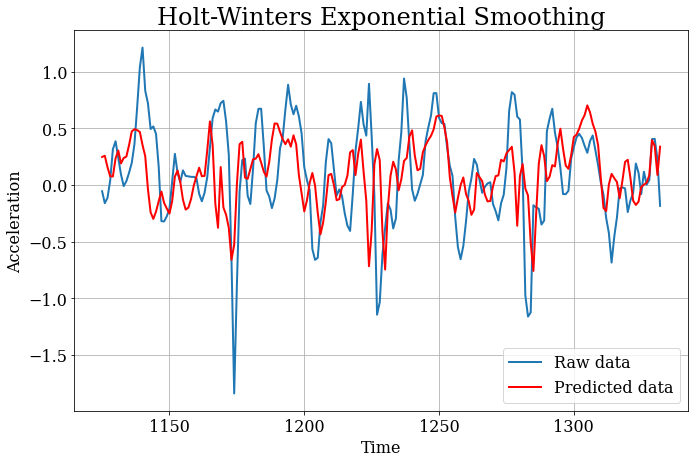

In [19]:
models = [SimpleExpSmoothing, Holt, ExponentialSmoothing]
names = ["SimpleExpSmoothing", "DoubleExpSmoothing", "Holt-Winters Exponential Smoothing"]
errors = []
for model, name in zip(models, names):
  if name == "Holt-Winters Exponential Smoothing":
    opt_smoothing = model(train, trend='add', seasonal='add', seasonal_periods=500).fit(optimized=True, use_boxcox=False, remove_bias=False)
  elif name == "DoubleExpSmoothing":
    opt_smoothing = model(train).fit(optimized=True, use_boxcox=False, remove_bias=False)
  else:
    opt_smoothing = model(train).fit(smoothing_level=0.2, optimized=False)
  predicted = opt_smoothing.forecast(test.index[-1] - train.index[-1])
  errors.append((mean_absolute_percentage_error(test, predicted), mean_absolute_error(test, predicted)))

  plt.plot(test, label = "Raw data")
  plt.plot(predicted, label = "Predicted data", c='red')
  plt.xlabel("Time")
  plt.ylabel("Acceleration")
  plt.title(name)
  plt.grid()
  plt.legend()
  plt.show()

In [20]:
for name, error in zip(names, errors):
  print(f"mean absolute percentage error for {name} is {error[0]} and mean absolute error us {error[1]}")

mean absolute percentage error for SimpleExpSmoothing is 1.0317767385148622 and mean absolute error us 0.3465183053342399
mean absolute percentage error for DoubleExpSmoothing is 2.731689336599765 and mean absolute error us 0.3644163456330112
mean absolute percentage error for Holt-Winters Exponential Smoothing is 1.8412864893093965 and mean absolute error us 0.330074934267909


## III) MAE analysis 

In [21]:
test_beg_ind = 1100
test_end_ind = 1332
exp_am = 20
step = int((test_end_ind - test_beg_ind) / exp_am)
steps = []

train= data['userAcceleration.x'].iloc[0:test_beg_ind]
models = [SimpleExpSmoothing(train).fit(optimized=True, use_boxcox=False, remove_bias=False), 
          Holt(train).fit(optimized=True, use_boxcox=False, remove_bias=False), 
          ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=500).fit(optimized=True, use_boxcox=False, remove_bias=False)]

names = ["SimpleExpSmoothing", "DoubleExpSmoothing", "Holt-Winters Exponential Smoothing"]

errors = {"SimpleExpSmoothing" : [],
          "DoubleExpSmoothing" : [],
          "Holt-Winters Exponential Smoothing" : []}

forecast_am = 0
for i in range(exp_am):
  forecast_am += step 
  if (i + 1) % 10 == 0:
    print(f"Progress: ({i + 1})/({exp_am})")
  steps.append(forecast_am)
  test = data['userAcceleration.x'].iloc[test_beg_ind:test_beg_ind + forecast_am]
  for model, name in zip(models, names):
    predicted = model.forecast(forecast_am)
    errors[name].append(mean_absolute_error(test, predicted))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


Progress: (10)/(20)
Progress: (20)/(20)


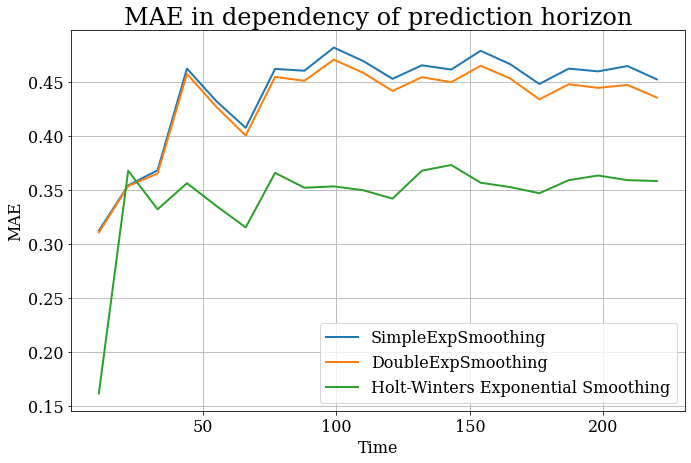

In [22]:
for name in errors.keys():
  plt.plot(steps, errors[name], label = name)
plt.xlabel("Time")
plt.ylabel("MAE")
plt.title("MAE in dependency of prediction horizon")
plt.grid()
plt.legend()
plt.show()

# 4) Final results and conclusions

As we can see on graphs and from MAPE and MAE analysis Holt-Winters Exponential Smoothing is better in accuracy and pattern likelihood. Simple Exponential Smoothing due to the theory can predict only one step ahead of train dataset, so we see it in practise. Double Exponential Smooting understands the trend of the train dataset (the prerdiction line is not horizontal) but cannot catch up with the pattern. 